## This notebook is to solve the formulation suggested by Prof. Callies

In [28]:
import P
import numpy as np
from scipy.interpolate import CubicSpline
import matplotlib.pyplot as plt
import casadi as ca
import pandas as pd

In [59]:
##define the small section of the track
s0=300
s_end=600
ds=3

##define sj, the points needs to check safety
sj=np.arange(s0, s_end, 120)

##define a toy fov
def fov(s):
    return s+60

In [60]:
sj

array([300, 420, 540])

In [61]:
##==car parameter==##
car_param = {
    "m": 1500,          # mass [kg]
    "g": 9.81,          # gravity [m/s^2]
    "mu_roll": 0.008,   # rolling resistance coefficient
    "mu": 1,            # friction coefficient
    "F_MAX": 2000,      # maximum driving force [N]
    "F_MIN": -13200,    # maximum braking force [N]
    "delta_MAX": np.pi / 6, # maximum steering angle [rad]
    "J_zz": 3000,       # yaw inertia [kg*m^2]
    "l_f": 1.5,         # distance from CoG to front axle [m]
    "l_r": 1.5,         # distance from CoG to rear axle [m]
    "w_f": 1.2,         # front track width [m]
    "w_r": 1.2          # rear track width [m]
}

      # x_m        y_m  w_tr_right_m  w_tr_left_m
0 -0.320123   1.087714         5.739        5.932
1  0.168262   6.062191         5.735        5.929
2  0.656139  11.036647         5.731        5.926
3  1.143549  16.011082         5.727        5.923
4  1.630535  20.985493         5.723        5.920


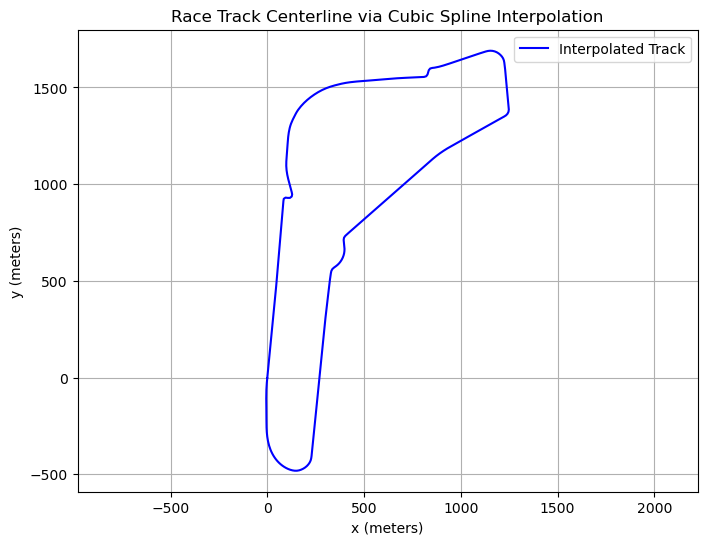

In [62]:
##==load track kappa==##
# 1. set file path
file_path = "Monza.csv"

# 2. read csv file
df = pd.read_csv(file_path)

# 3. look head
print(df.head())

# 4. rename the first row
##df.rename(columns={'# x_m': 'x_m'}, inplace=True)

# 5. read the columns
x = df['# x_m'].values
y = df['y_m'].values
w_left = df['w_tr_left_m'].values
w_right = df['w_tr_right_m'].values

# Step 1: Compute arclengths
s = np.zeros(len(x))
s[1:] = np.cumsum(np.sqrt(np.diff(x)**2 + np.diff(y)**2))
s_max=s[-1] #the length of the track

# Step 2: Create cubic spline interpolators
x_spline = CubicSpline(s, x)
y_spline = CubicSpline(s, y)

# Step 3: Get the first and second derivative of the parameteriation
dx_ds = x_spline.derivative(1)
d2x_ds2 = x_spline.derivative(2)
dy_ds = y_spline.derivative(1)
d2y_ds2 = y_spline.derivative(2)

## Generate interpolated values for plotting
s_query = np.linspace(0, s_max, 500)
x_interp = x_spline(s_query)
y_interp = y_spline(s_query)

## Plot the spline
plt.figure(figsize=(8, 6))
plt.plot(x_interp, y_interp, label='Interpolated Track', color='blue')
##plt.plot(x, y, 'ro', label='Original Points')
plt.axis('equal')
plt.title('Race Track Centerline via Cubic Spline Interpolation')
plt.xlabel('x (meters)')
plt.ylabel('y (meters)')
plt.legend()
plt.grid(True)
plt.show()

# output parameterisation and curvature as a casadi instance
x_ref = ca.interpolant('x_ref', 'linear', [s_query], x_interp)
y_ref = ca.interpolant('y_ref', 'linear', [s_query], y_interp)
kappa_ref_ = dx_ds(s_query)*d2y_ds2(s_query)-dy_ds(s_query)*d2x_ds2(s_query)
kappa_ref = ca.interpolant('kappa', 'linear', [s_query], kappa_ref_)

In [63]:
##==load global solution==##
# file path
file_path = './optimal_trajectory_10000.csv'

# read CSV
df = pd.read_csv(file_path)

# look first 5 entry
print(df.head())

#  Use boolean indexing to filter rows where s is between 3690 and 3972.
mask = (df['s'] >= s0) & (df['s'] <= s_end)
df_sub = df.loc[mask]
global_sub={}

#  add corresponding values in global_sub
global_sub["s"]     = df_sub['s'].to_numpy()
global_sub["v"]     = df_sub['v'].to_numpy()
global_sub["beta"]  = df_sub['beta'].to_numpy()
global_sub["psi_dot"] = df_sub['omega'].to_numpy()
global_sub["n"]     = df_sub['n'].to_numpy()
global_sub["xi"]    = df_sub['xi'].to_numpy()
global_sub["delta_f"] = df_sub['delta'].to_numpy()[:-1]
global_sub["F_dr"]   = df_sub['F_dr'].to_numpy()[:-1]

      s          v      beta     omega             n        xi     delta  \
0   0.0  10.000000  0.000000  0.000000  0.000000e+00  0.000000  0.145753   
1   3.0  10.043576  0.000087  0.001246  1.303288e-12 -0.000031  0.146159   
2   6.0  10.086767 -0.000199  0.002485  1.681016e-04  0.000295  0.146300   
3   9.0  10.129588 -0.000850  0.003710  4.553829e-04  0.000975  0.146143   
4  12.0  10.172052 -0.001854  0.004914  8.290615e-04  0.002017  0.145717   

         F_dr  
0  369.457680  
1  368.831195  
2  368.243115  
3  367.688135  
4  367.164628  


In [64]:
##==define x_start==##
x_start={}
x_start["n"]=global_sub["n"][0]
x_start["xi"]=global_sub["xi"][0]
x_start["beta"]=global_sub["beta"][0]
x_start["psi_dot"]=global_sub["psi_dot"][0]
x_start["v"]=global_sub["v"][0]

## Test for solving $P_1$

In [65]:
opti, n, xi, beta, psi_dot, v, delta_f, F_dr, n_im, xi_im, beta_im, psi_dot_im, v_im, delta_f_im, F_dr_im=P.P_i_opt(car_param,ds,s0,s_end,kappa_ref,global_sub,None,sj,fov,1,x_start)

In [66]:
opti.solver('ipopt', {"expand": True}, {
        "print_level": 0, "tol": 1e-4,
        "acceptable_tol": 1e-2, "acceptable_iter": 10,
        "max_iter": 10000,
        "constr_viol_tol": 1e-3,
        "compl_inf_tol": 1e-3,
        "acceptable_constr_viol_tol": 1e-3,
    })

In [67]:
sol = opti.solve()

      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 550.00us (  1.05us) 505.17us (962.23ns)       525
       nlp_g  |  42.05ms ( 80.10us)  42.06ms ( 80.11us)       525
  nlp_grad_f  | 624.00us (  2.35us) 593.92us (  2.24us)       265
  nlp_hess_l  | 122.22ms (473.72us) 122.26ms (473.88us)       258
   nlp_jac_g  |  55.39ms (197.84us)  55.56ms (198.44us)       280
       total  |   1.64 s (  1.64 s)   1.64 s (  1.64 s)         1


In [68]:
opti.debug.value(v)

array([13.12460379, 13.16447515, 13.20483539, 13.24550046, 13.28630394,
       13.3270959 , 13.367754  , 13.4082056 , 13.44839635, 13.48828427,
       13.52783709, 13.56703294, 13.60585716, 13.64429699, 13.68234103,
       13.71997886, 13.75720164, 13.79400021, 13.83036805, 13.86629897,
       13.90178819, 13.93683091, 13.97142313, 14.00556189, 14.03924495,
       14.07246985, 14.1052323 , 14.13753514, 14.16938362, 14.20078622,
       14.23175581, 14.26230954, 14.29246762, 14.32225201, 14.35168446,
       14.38078462, 14.40955998, 14.43801448, 14.46614716, 14.49396755,
       14.52147529, 14.54867211, 14.57555987, 14.60213803, 14.62840606,
       14.65436353, 14.68001593, 14.70536423, 14.73041781, 14.75516056,
       14.77959702, 14.80372464, 14.82756944, 14.85109071, 14.87425568,
       14.89709629, 14.91961663, 14.94180451, 14.96364801, 14.98512845,
       15.00627167, 15.02710691, 15.04763756, 15.06788526, 15.08785945,
       15.1075681 , 15.12700918, 15.14617469, 15.16505369, 15.18

In [69]:
opti.debug.value(F_dr_im[0])

array([-2030.34348994, -2012.6203751 , -1995.77314356, -1980.99530309,
       -1970.85834181, -1961.63382701, -1956.35212762, -1957.60939341,
       -1966.34708681, -1974.60343708, -2010.09604195, -2058.29019808,
       -2134.51033337, -2237.97725323, -2379.13218831, -2584.65413151,
       -2871.48023021, -3289.45621016, -3862.32930496, -4224.60192817])

In [70]:
opti.debug.value(v_im[0])

array([13.12460379, 12.79848699, 12.46708835, 12.1298861 , 11.78610421,
       11.43444357, 11.07409209, 10.70358849, 10.32079258,  9.92307389,
        9.50896267,  9.07103125,  8.60357092,  8.09627609,  7.53641203,
        6.90474002,  6.16845842,  5.27589753,  4.13073808,  2.56077191,
        0.48301404])

## Define a loop to solve $P_i$, $i=1,2,...,M$ recursively

In [71]:
M=len(sj)
sol_realcar=global_sub
sol_pre_P=[] #sol_pre_P[i]["n"] is the array constaining solution states n of imaginary car i+1.
for i in range(1,M+1):
    opti, n, xi, beta, psi_dot, v, delta_f, F_dr, n_im, xi_im, beta_im, psi_dot_im, v_im, delta_f_im, F_dr_im=P.P_i_opt(car_param,ds,s0,s_end,kappa_ref,sol_realcar,sol_pre_P,sj,fov,i,x_start)
    opti.solver('ipopt', {"expand": True}, {
        "print_level": 0, "tol": 1e-4,
        "acceptable_tol": 1e-2, "acceptable_iter": 10,
        "max_iter": 10000,
        "constr_viol_tol": 1e-3,
        "compl_inf_tol": 1e-3,
        "acceptable_constr_viol_tol": 1e-3,
    })
    try:
        sol = opti.solve() # 这一行是关键！
    except RuntimeError as e:
        print(f"Optimization failed: {e}")
        break
    
    # get the optimization results for the real car
    n_opt = sol.value(n)
    xi_opt = sol.value(xi)
    beta_opt = sol.value(beta)
    psi_dot_opt = sol.value(psi_dot)
    v_opt = sol.value(v)
    delta_f_opt = sol.value(delta_f)
    F_dr_opt = sol.value(F_dr)
    
    sol_realcar['n'] = n_opt
    sol_realcar['xi'] = xi_opt
    sol_realcar['beta'] = beta_opt
    sol_realcar['psi_dot'] = psi_dot_opt
    sol_realcar['v'] = v_opt
    sol_realcar['delta_f'] = delta_f_opt
    sol_realcar['F_dr'] = F_dr_opt
    
    # get the optimization results for the imaginary cars
    for l in range(i):
        im_opt_current={}
        im_opt_current["n"]=sol.value(n_im[l])
        im_opt_current["xi"]=sol.value(xi_im[l])
        im_opt_current["beta"]=sol.value(beta_im[l])
        im_opt_current["psi_dot"]=sol.value(psi_dot_im[l])
        im_opt_current["v"]=sol.value(v_im[l])
        im_opt_current["delta_f"]=sol.value(delta_f_im[l])
        im_opt_current["F_dr"]=sol.value(F_dr_im[l])
        
        sol_pre_P.append(im_opt_current)
    
    

      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 506.00us (963.81ns) 479.80us (913.90ns)       525
       nlp_g  |  41.70ms ( 79.44us)  41.55ms ( 79.15us)       525
  nlp_grad_f  | 594.00us (  2.24us) 566.95us (  2.14us)       265
  nlp_hess_l  | 122.19ms (473.60us) 122.39ms (474.36us)       258
   nlp_jac_g  |  55.09ms (196.74us)  55.25ms (197.31us)       280
       total  |   1.64 s (  1.64 s)   1.64 s (  1.64 s)         1
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |   3.93ms (933.52ns)   3.64ms (864.54ns)      4212
       nlp_g  | 386.13ms ( 91.67us) 385.42ms ( 91.50us)      4212
  nlp_grad_f  |   3.40ms (  2.27us)   3.25ms (  2.17us)      1499
  nlp_hess_l  | 775.27ms (530.28us) 776.61ms (531.19us)      1462
   nlp_jac_g  | 363.41ms (225.16us) 364.36ms (225.75us)      1614
       total  |  10.53 s ( 10.53 s)  10.53 s ( 10.53 s)         1
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp

In [72]:
sol_realcar['n']

array([-3.47325073, -3.55067478, -3.66798823, -3.78619312, -3.89366739,
       -3.99082099, -4.0780533 , -4.15575524, -4.2241129 , -4.28345907,
       -4.33415964, -4.41906958, -4.49299679, -4.55668303, -4.61158598,
       -4.68107099, -4.74251975, -4.79947353, -4.85555214, -4.91048236,
       -4.95597111, -4.99194784, -5.01863135, -5.03713981, -5.0480786 ,
       -5.04947415, -5.06302084, -5.15814162, -5.23577901, -5.2974188 ,
       -5.34434663, -5.37772338, -5.39784787, -5.40845603, -5.40689417,
       -5.3940756 , -5.44765784, -5.48595154, -5.50865391, -5.51634919,
       -5.50957758, -5.48886376, -5.5657017 , -5.62091817, -5.65652505,
       -5.67434848, -5.67582452, -5.66406236, -5.65127228, -5.63298902,
       -5.60859404, -5.58081222, -5.55373142, -5.54747377, -5.54343131,
       -5.53595147, -5.52420418, -5.50764812, -5.48676399, -5.46310208,
       -5.45143339, -5.4402688 , -5.42447364, -5.39701724, -5.35735141,
       -5.30793949, -5.24940738, -5.18184622, -5.1058831 , -5.02

In [73]:
sol_realcar['v']

array([13.12460379, 11.3160824 , 11.27603984, 11.59377057, 11.901467  ,
       12.19943254, 12.48797963, 12.7674749 , 13.03811614, 13.30021311,
       12.21197818, 12.48523474, 12.74376209, 12.96748763, 12.57087993,
       12.75708843, 12.85814675, 12.8713696 , 12.89074527, 13.09997279,
       13.3133038 , 13.52412091, 13.71078172, 13.88429718, 14.10967219,
       13.82039983, 11.98764427, 12.26852242, 12.53263942, 12.78137575,
       13.01928857, 13.25668902, 13.42917924, 13.65364453, 13.86500134,
       12.56118403, 12.79492895, 13.03993091, 13.28231593, 13.52237505,
       13.75997008, 11.98904093, 12.27130686, 12.53718734, 12.78665458,
       13.02322125, 13.2188436 , 13.22352192, 13.29891574, 13.38446821,
       13.42676668, 13.40329792, 13.06053196, 13.01377619, 13.05030523,
       13.0988592 , 13.15535121, 13.20486692, 13.23153109, 13.04072028,
       13.01852025, 13.06824192, 13.21686762, 13.37643282, 13.50365498,
       13.62372882, 13.74425378, 13.85708629, 13.94734389, 13.53

In [74]:
sol_pre_P[0]['v']

array([13.12460379, 12.79848699, 12.46708835, 12.1298861 , 11.78610421,
       11.43444357, 11.07409209, 10.70358849, 10.32079258,  9.92307389,
        9.50896267,  9.07103125,  8.60357092,  8.09627609,  7.53641203,
        6.90474002,  6.16845842,  5.27589753,  4.13073808,  2.56077191,
        0.48301404])

In [77]:
sol_pre_P[0]['F_dr']

array([-2030.34348994, -2012.6203751 , -1995.77314356, -1980.99530309,
       -1970.85834181, -1961.63382701, -1956.35212762, -1957.60939341,
       -1966.34708681, -1974.60343708, -2010.09604195, -2058.29019808,
       -2134.51033337, -2237.97725323, -2379.13218831, -2584.65413151,
       -2871.48023021, -3289.45621016, -3862.32930496, -4224.60192817])

In [75]:
sol_pre_P[1]['v']

array([13.12460379, 13.00384371, 12.87123063, 12.72569868, 12.56589922,
       12.3900571 , 12.19642175, 11.98249674, 11.74518671, 11.48049451,
       11.18345149, 10.84637992, 10.45954539, 10.00888583,  9.4747423 ,
        8.82709193,  8.01731917,  6.96621003,  5.5300063 ,  3.42947531,
        0.12709764])

In [78]:
sol_pre_P[1]['F_dr']

array([ -677.29019624,  -747.89235288,  -823.24036814,  -904.68852612,
        -994.25387344, -1090.88591529, -1198.19044708, -1318.3348926 ,
       -1454.69051269, -1610.15795223, -1796.28089404, -2018.03060576,
       -2289.15763711, -2623.12142077, -3044.96957695, -3594.69262842,
       -4311.92901843, -5255.91531142, -6428.85930349, -7378.29686772])

In [76]:
sol_pre_P[2]['v']

array([14.12492583, 14.04785626, 13.93491637, 13.75737006, 13.49649016,
       13.24903127, 13.08992795, 13.03039252, 13.05871831, 13.15973908,
       13.31096725, 13.49810378, 13.70452859, 13.90422772, 14.03448564,
       12.77711704, 10.91894964,  8.71359807,  6.11993299,  3.02679548,
        0.4999728 ])

In [79]:
sol_pre_P[2]['F_dr']

array([  -440.84541056,   -701.09985805,  -1165.94904408,  -1752.55127515,
        -1627.40986111,   -983.73114647,   -284.23785256,    323.50750238,
          827.80760062,   1184.20549066,   1449.91068925,   1606.03390171,
         1578.92317815,   1087.77983067,  -9224.77265062, -12626.54607375,
       -13194.68955686, -13199.8735257 , -13199.89361996, -13199.90185883])